### Time Series Generative Adverserial Network (TimeGAN)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

np.random.seed(42)
tf.random.set_seed(1234)

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [5]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [6]:
experiment = 0

In [7]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

hdf_store = results_path / 'TimeSeriesGAN.h5'

In [8]:
data_path = '/content/drive/MyDrive/BBG Capstone Summer 2023/Data/timegan_data_cat.csv'
df = pd.read_csv(data_path)

In [9]:
df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
df.set_index(zip(df['Unnamed: 0'], df['Dates']), inplace=True)
df.drop(columns = ['Unnamed: 0', 'Dates'], inplace = True)
df

CUR_RATIO  QUICK_RATIO  INTEREST_COVERAGE_RATIO  \
VZ UN Equity  2015-03-31     0.7953       0.6140                   5.7556   
              2015-06-30     0.7016       0.5469                   5.6756   
              2015-09-30     0.6311       0.5012                   5.4365   
              2015-12-31     0.6378       0.5214                   7.1805   
              2016-03-31     0.7089       0.5503                   5.8569   
...                             ...          ...                      ...   
LYB UN Equity 2022-03-31     1.7630       0.9122                  22.4459   
              2022-06-30     1.6784       0.8108                  36.9138   
              2022-09-30     1.6149       0.7374                  11.6000   
              2022-12-31     1.7522       0.8200                   5.7294   
              2023-03-31     1.8462       0.8452                   6.1466   

                          TOT_DEBT_TO_TOT_EQY  TOT_DEBT_TO_TOT_CAP  \
VZ UN Equity  2015-03-31            1053.8898              91.3337   
              2015-06-30             882.9501              89.8265   
              2015-09-30             772.4109              88.5375   
              2015-12-31             615.0039              86.0141   
              2016-03-31             546.5851              84.5341   
...                                       ...                  ...   
LYB UN Equity 2022-03-31             100.8263              50.2057   
              2022-06-30             105.5340              51.3462   
              2022-09-30             104.1481              51.0159   
              2022-12-31             103.3901              50.8334   
              2023-03-31             100.2646              50.0661   

                          ASSET_TURNOVER  MODIFIED_WORK_CAP_TURN  IS_EPS  \
VZ UN Equity  2015-03-31          0.5608                  9.5755    1.03   
              2015-06-30          0.5546                  9.0099    1.04   
              2015-09-30          0.5575                  9.0311    0.99   
              2015-12-31          0.5521                 14.1855    1.32   
              2016-03-31          0.5488                  9.6206    1.06   
...                                  ...                     ...     ...   
LYB UN Equity 2022-03-31          1.3654                  8.6949    4.01   
              2022-06-30          1.4411                  8.3764    5.00   
              2022-09-30          1.4125                  8.6406    1.75   
              2022-12-31          1.3802                  9.0935    1.07   
              2023-03-31          1.2830                  8.1427    1.45   

                          PX_TO_BOOK_RATIO  PE_RATIO  ...  NET_INCOME  \
VZ UN Equity  2015-03-31           21.2375   10.4682  ...      4219.0   
              2015-06-30           16.6011    9.7510  ...      4231.0   
              2015-09-30           13.4752    8.8216  ...      4038.0   
              2015-12-31           11.4598   11.6028  ...      5391.0   
              2016-03-31           11.8258   13.8028  ...      4310.0   
...                                    ...       ...  ...         ...   
LYB UN Equity 2022-03-31            2.6530    5.3216  ...      1318.0   
              2022-06-30            2.3402    4.7556  ...      1643.0   
              2022-09-30            2.0107    4.9836  ...       570.0   
              2022-12-31            2.1439    6.6654  ...       351.0   
              2023-03-31            2.4022    8.5658  ...       472.0   

                          INVENT_TURN  RETURN_COM_EQY  RETURN_ON_ASSET  \
VZ UN Equity  2015-03-31      51.9550         89.7687           4.3280   
              2015-06-30      46.0846         75.3458           4.2624   
              2015-09-30      41.3885         69.0358           4.3799   
              2015-12-31      43.7064        124.4796           7.4997   
              2016-03-31      47.8566        128.4489           7.4816   
...                       

In [11]:
stocks = df.index.get_level_values(0).unique()
n_stocks = len(stocks)
total_timesteps = len(df.loc[stocks[0], :])
n_cat = 1
n_tem = len(df.columns) - n_cat


print(f'No. of stocks = {n_stocks}\nTotal timesteps per stock = {total_timesteps}\nNumber of Sequences = {n_tem}\nNo. of classifications : {n_cat}')

No. of stocks = 178
Total timesteps per stock = 33
Number of Sequences = 26
No. of classifications : 1


In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, :n_tem]).astype(np.float32)
df.iloc[:, :n_tem] = pd.DataFrame(scaled_data, index = df.index, columns= df.columns[:n_tem])

# TimeGAN Architecture and Training

## Combining adversarial and supervised training with time-series embedding

TimeGAN explicitly incorporates the autoregressive nature of time series by combining the unsupervised adversarial loss on both real and synthetic sequences with a stepwise supervised loss with respect to the original data. The goal is to reward the model for learning the distribution over transitions from one point in time to the next present in the historical data.

Furthermore, TimeGAN includes an embedding network that maps the time-series features to a lower-dimensional latent space to reduce the complexity of the adversarial space. The motivation is to capture the drivers of temporal dynamics that often have lower dimensionality.

A **key element** of the TimeGAN architecture is that both the generator and the embedding (or autoencoder) network are responsible for minimizing the supervised loss that measures how well the model learns the dynamic relationship.

As a result, the model learns a latent space conditioned on facilitating the generator’s task to faithfully reproduce the temporal relationships observed in the historical data. In addition to time-series data, the model can also process *static* data that do not change or change less frequently over time.

## The four components of the TimeGAN architecture
The TimeGAN architecture combines an adversarial network with an autoencoder and has thus **four network components** as depicted in the below Figure:
- **Autoencoder**: embedding and recovery networks
- **Adversarial Network**: sequence generator and sequence discriminator components

<img src="https://i.imgur.com/2QurkKl.png" title="source: imgur.com" width="600"/>

The **embedding and recovery components** of the autoencoder map the feature space into the latent space and vice versa to facilitate the learning of the temporal dynamics by the adversarial network learns in a lower-dimensional space. The authors implement the embedding and recovery network using a stacked RNN and a feedforward network. However, these choices can be flexibly adapted to the task at hand as long as they are autoregressive and respect the temporal order of the data.

The **generator and discriminator elements** of the adversarial network differ from the DCGAN not only because they operate on sequential data but also because the synthetic features are generated in the latent space that the model learns simultaneously. The authors choose an RNN as generator and a bidirectional RNN with a feedforward output layer for the discriminator.

## Joint training of autoencoder and adversarial network
The three loss functions displayed in the Figure above drive the joint optimization of the network elements just described while training on real and randomly generated time series.
- The **reconstruction loss** compares how well the reconstruction of the encoded data resembles the original.
- The **unsupervised loss** reflects the competitive interaction between the generator and the discriminator.While the generator aims to minimize the probability that the discriminator classifies its output as fake, the discriminator aims to optimize the correct classification or real and fake inputs.
- The **supervised loss** captures how well the generator approximates the actual next time step in latent space when receiving encoded real data for the prior sequence.

As a result of the joint training, TimeGAN simultaneously learns to encode features, generate representations, and iterate across time. More specifically, the embedding network creates the latent space, the adversarial network operates within this space, and supervised loss synchronizes the latent dynamics of both real and synthetic data.

## Training in three phases

Training proceeds along the following three phases:
1. Train the autoencoder on real time series to optimize reconstruction
2. Optimize the supervised loss using real time series to capture the temporal dynamics of the historical data
3. Jointly train the four components while minimizing all three loss functions

TimeGAN includes several hyperparameters used to weigh the components of composite loss functions; however, the authors find the network to be less sensitive to these settings than one might expect given the notorious difficulties of GAN training. In fact, they do not discover significant challenges during training and suggest that the embedding task serves to regularize adversarial learning because it reduces its dimensionality while the supervised loss constrains the stepwise dynamics of the generator.

In [16]:
#Parameters
seq_len = 8
n_seq = n_tem + n_cat
batch_size = 128

In [17]:
data = []
for stock_arr in df.values:
  for i in range(len(stock_arr) - seq_len):
    data.append(scaled_data[i: i + seq_len])
n_windows = len(data)
print(n_windows)

111606


In [18]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [19]:
def make_random_data():
    while True:
        yield np.random.normal(loc=0.0, scale=1.0, size=(seq_len, n_seq))

In [ ]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [ ]:
hidden_dim = 64
num_layers = 3

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [ ]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [ ]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [ ]:
embedder = make_rnn(n_layers=3,
                    hidden_units=hidden_dim,
                    output_units=hidden_dim,
                    name='Embedder')
recovery = make_rnn(n_layers=3,
                    hidden_units=hidden_dim,
                    output_units=n_seq,
                    name='Recovery')

In [ ]:
generator = make_rnn(n_layers=3,
                     hidden_units=hidden_dim,
                     output_units=hidden_dim,
                     name='Generator')
discriminator = make_rnn(n_layers=3,
                         hidden_units=hidden_dim,
                         output_units=1,
                         name='Discriminator')
supervisor = make_rnn(n_layers=2,
                      hidden_units=hidden_dim,
                      output_units=hidden_dim,
                      name='Supervisor')

In [ ]:
train_steps = 20000
gamma = 1 #controls the supervised loss of the generator (hyperparameter)

In [ ]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [ ]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [ ]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 8, 26)]           0         
                                                                 
 Embedder (Sequential)       (None, 8, 64)             71744     
                                                                 
 Recovery (Sequential)       (None, 8, 26)             76570     
                                                                 
Total params: 148,314
Trainable params: 148,314
Non-trainable params: 0
_________________________________________________________________


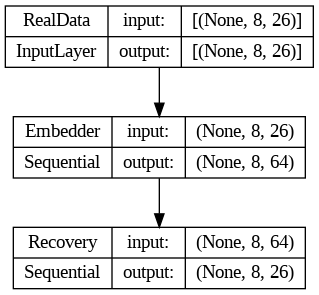

In [ ]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

In [ ]:
autoencoder_optimizer = Adam()

In [ ]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 20000/20000 [03:53<00:00, 85.80it/s] 


In [ ]:
autoencoder.save(log_dir / 'autoencoder')

In [ ]:
supervisor_optimizer = Adam()

In [ ]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 20000/20000 [02:22<00:00, 140.81it/s]


In [ ]:
supervisor.save(log_dir / 'supervisor')

In [ ]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 8, 26)]           0         
                                                                 
 Generator (Sequential)      (None, 8, 64)             71744     
                                                                 
 Supervisor (Sequential)     (None, 8, 64)             54080     
                                                                 
 Discriminator (Sequential)  (None, 8, 1)              74945     
                                                                 
Total params: 200,769
Trainable params: 200,769
Non-trainable params: 0
_________________________________________________________________


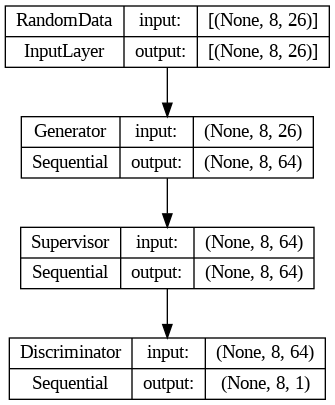

In [ ]:
plot_model(adversarial_supervised, show_shapes=True)

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 8, 26)]           0         
                                                                 
 Generator (Sequential)      (None, 8, 64)             71744     
                                                                 
 Discriminator (Sequential)  (None, 8, 1)              74945     
                                                                 
Total params: 146,689
Trainable params: 146,689
Non-trainable params: 0
_________________________________________________________________


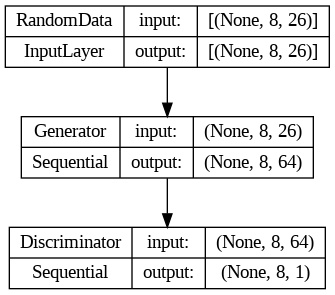

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [ ]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 8, 26)]           0         
                                                                 
 Generator (Sequential)      (None, 8, 64)             71744     
                                                                 
 Supervisor (Sequential)     (None, 8, 64)             54080     
                                                                 
 Recovery (Sequential)       (None, 8, 26)             76570     
                                                                 
Total params: 202,394
Trainable params: 202,394
Non-trainable params: 0
_________________________________________________________________


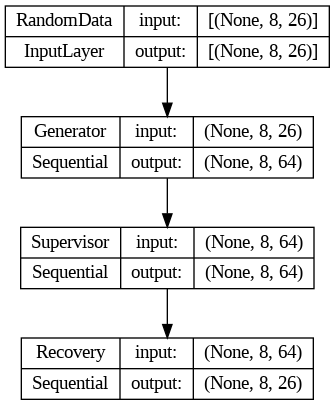

In [ ]:
plot_model(synthetic_data, show_shapes=True)

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 8, 26)]           0         
                                                                 
 Embedder (Sequential)       (None, 8, 64)             71744     
                                                                 
 Discriminator (Sequential)  (None, 8, 1)              74945     
                                                                 
Total params: 146,689
Trainable params: 146,689
Non-trainable params: 0
_________________________________________________________________


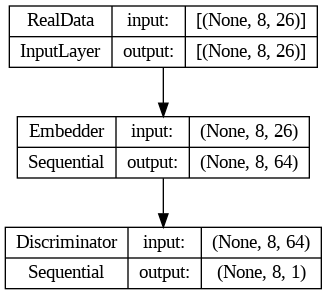

In [ ]:
plot_model(discriminator_model, show_shapes=True)

In [ ]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0794 | g_loss_u: 0.6995 | g_loss_s: 0.0000 | g_loss_v: 0.0186 | e_loss_t0: 0.0247
 1,000 | d_loss: 1.9511 | g_loss_u: 1.1150 | g_loss_s: 0.0000 | g_loss_v: 0.0149 | e_loss_t0: 0.0229
 2,000 | d_loss: 2.1488 | g_loss_u: 1.1319 | g_loss_s: 0.0000 | g_loss_v: 0.0041 | e_loss_t0: 0.0058
 3,000 | d_loss: 1.8709 | g_loss_u: 1.0440 | g_loss_s: 0.0000 | g_loss_v: 0.0026 | e_loss_t0: 0.0036
 4,000 | d_loss: 1.8989 | g_loss_u: 1.1024 | g_loss_s: 0.0000 | g_loss_v: 0.0026 | e_loss_t0: 0.0024
 5,000 | d_loss: 1.8233 | g_loss_u: 1.1022 | g_loss_s: 0.0000 | g_loss_v: 0.0033 | e_loss_t0: 0.0022
 6,000 | d_loss: 1.9630 | g_loss_u: 1.1493 | g_loss_s: 0.0000 | g_loss_v: 0.0042 | e_loss_t0: 0.0015
 7,000 | d_loss: 1.8959 | g_loss_u: 1.0409 | g_loss_s: 0.0000 | g_loss_v: 0.0031 | e_loss_t0: 0.0012
 8,000 | d_loss: 1.8929 | g_loss_u: 1.1157 | g_loss_s: 0.0000 | g_loss_v: 0.0033 | e_loss_t0: 0.0011
 9,000 | d_loss: 1.8428 | g_loss_u: 1.1231 | g_loss_s: 0.0000 | g_loss_v: 0.0029 | e_loss_t

In [ ]:
synthetic_data.save(log_dir / 'synthetic_data')

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

34

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4352, 8, 26)

In [ ]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [ ]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=df.columns))